## Libraries

In [2]:
import sys
path = '/content/drive/MyDrive/Univalle/Tesis/Tesis V1'

sys.path.append(path)

import tools as tl
import config as cf

In [3]:


import cv2
import pandas as pd
import numpy as np
import os

from skimage.feature import hog
from skimage.util import view_as_windows # Sliding window
from keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier 
from sklearn.model_selection import GridSearchCV # Search best params models
from joblib import dump, load # Save and load models

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()

from keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers




## Functions

In [4]:
def load_dataset_detector(): 
    print("Loading dataset...")
    images = []
    targets = []

    for folder in range(9):
        for image in range(16):
            path = cf.main_path+"ds_segmented/"+str(folder)+"/s"+str(folder)+"_"+str(image)+".jpg"
            img_i = cv2.imread(path,0)
            images.append(img_i)
            targets.append(1)

    for i in range(len(targets)):
        path = cf.main_path+"ds_segmented/Negative/"+str(i)+".jpg"
        img_i = cv2.imread(path,0)
        images.append(img_i)
        targets.append(0)

    return images, targets
# CARACTERISTICAS HOG:

def augmented_detection_data(img_vector,targ,augmentation=1):
    print("Increasing data...")
    count = 0

    images_out = []
    targets_out = []
    
    for i in range(len(img_vector)): # image by image
        img_i = img_vector[i]
        targ_i = targ[i]
        
        images_out.append(img_i/255)
        targets_out.append(targ_i)

        data = img_to_array(img_i)
        samples = np.expand_dims(data, 0)
        # Images generator
        datagen = ImageDataGenerator(#zoom_range=0.6, # Disable because width and height aren't proportional (distortion)
	    							brightness_range=[0.6,1.1],
	    							height_shift_range=[-2,2],
	    							width_shift_range=[-2,2],
                    rotation_range=360,
                    horizontal_flip = True,
                    vertical_flip = True,
                   
                                    )
        it = datagen.flow(samples, batch_size=1)
        for i in range(augmentation):
            batch = it.next() # Output: tensor img [x,y,1]
            aug_img = batch[0].astype('uint8')
            aug_img = aug_img.reshape((aug_img.shape[0],aug_img.shape[1]))/255
            
            images_out.append(aug_img)
            targets_out.append(targ_i)
            

            count+=1
        #count=0
    
    return images_out,targets_out

def detect_descriptor(img_vector): # Extrae el descriptor para la detección
    print("Extracting features...")
    descriptor = []
    for i in range(len(img_vector)):

        img_hog = hog_features(img_vector[i])
        descriptor_hog = hog_descriptor(img_hog)
        descriptor.extend([descriptor_hog])
        #descriptor.extend([img_vector[i].flatten()])
    return descriptor

def hog_features(img): # Convierte la img hog a 2D
	
	data = extract_hog_features(img)
	hog = np.zeros((np.array(data).shape[0],np.array(data).shape[1],9))
		
	for i in range(np.array(data).shape[0]):
		for j in range(np.array(data).shape[1]):
			x = np.array(data[i,j])
			hog[i,j] = x.flatten()

	return hog # = img_hog

def extract_hog_features(img): # Convierte una img a una img hog (output 3D)

    hog_feature = hog(img,
             		orientations= 9,
		            pixels_per_cell=(4,4),
		            cells_per_block = (1,1),
		            visualize = False,
    				feature_vector = False,
		            block_norm = "L1")
    return hog_feature

def hog_descriptor(img_hog): # Toma la img_hog 2D, toma 5 sub-ventanas, las concatena y aplana a 1D
	win_size = int(img_hog.shape[0]/cf.block) # Tamaño del bloque en Pixeles, cf.block = 2
	
	windows_list = view_as_windows(img_hog,(win_size,win_size,9),1) # Divide la imagen en 2x2 bloques sin superposicion entre ellas
	# x = img_hog[]
	descriptor = []
	for i in range(cf.block):
		for j in range(cf.block):
			window_hog = windows_list[i,j].flatten() 	# Obtiene el descriptor HOG de cada bloque
			descriptor.extend(window_hog)				# Concatena estos descriptores
	
	# Bloques solapados:
	pos = int((img_hog.shape[0]-win_size)/2)
	win_size_center = int(img_hog.shape[0]-win_size)
	img_center = img_hog[pos:pos+win_size_center,pos:pos+win_size_center,:]
	window_center_list = view_as_windows(img_center,(win_size,win_size,9),1)
	
	for i in range(cf.block-1):
		for j in range(cf.block-1):
			window_hog = window_center_list[i,j].flatten()
			descriptor.extend(window_hog)

	return descriptor

def db_augmented(img_vector,degrees_per_img=16,augmentation=3, shift = True): # in*2*(16+1)*(3+1) = in*204
    #print("Imgs per img: ",2*(degrees_per_img+1)*(augmentation+1))
    count = 0
    
    # Vertical flip *2
    flipped_imgs = img_vector.copy()
    for img_i in img_vector:
        flipped_imgs.append(cv2.flip(img_i, 1))
    
    # Rotation of images *(16+1)
    out_vector = []
    for img_i in flipped_imgs:
        for degre in range(0,360,int(360/degrees_per_img)):
            rotated_img = rotate(img_i,degre,mode='edge')
            out_vector.append(rotated_img)

    # Distance, Light and shift variation
    temp = out_vector.copy()
    for img_i in temp: # image by image
        data = img_to_array(img_i)
        samples = np.expand_dims(data, 0)
        # Images generator
        datagen = ImageDataGenerator(#zoom_range=0.6, # Disable because width and height aren't proportional (distortion)
	    							brightness_range=[0.5,1.3],
	    							height_shift_range=[-3,3],
	    							width_shift_range=[-3,3],
                                    )
        it = datagen.flow(samples, batch_size=1)
        for i in range(augmentation):
            batch = it.next() # Output: tensor img [x,y,1]
            aug_img = batch[0].astype('uint8')
            aug_img = aug_img.reshape((aug_img.shape[0],aug_img.shape[1]))/255
            out_vector.append(aug_img)

            count+=1
        #count=0
    
    return out_vector

def order_negative_data():
    i = 0
    path_save = cf.main_path+"ds_segmented/Negative/"
    for dirname, _, filenames in os.walk(cf.main_path+"ds_segmented/Negative/"):
        for filename in filenames:
            
            if len(os.path.join(dirname, filename)) < 74:
                img_i = cv2.imread(os.path.join(dirname, filename))
                
                cv2.imwrite(path_save + str(i)+".jpg", img_i)
                i+=1

def negative_data_generator():
    img_in = cv2.imread(cf.path_test,0)
    path_save = cf.main_path+"ds_segmented/Negative/"
    i = 0
    amount = int(16*8*4)
    print(amount)
    rel = 1.5
    y_val = int( np.sqrt( amount/rel ) )
    x_val = int( rel*y_val )
    print(x_val*y_val)
    windows_list = view_as_windows(img_in, cf.w_size, cf.w_step)
    x_step = np.random.randint(0,windows_list.shape[1],(x_val,1))
    y_step = np.random.randint(0,windows_list.shape[0],(y_val,1))
    
    for x in x_step:
        for y in y_step:
            window = windows_list[int(y),int(x)]
            path_i = path_save + str(i)+".jpg"
            cv2.imwrite(path_i, window)
            i += 1

def train_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    plt.figure()
    plt.title("History")
    plt.subplot(121)
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(hist["epoch"],hist["accuracy"],label="Train acc")
    plt.plot(hist["epoch"],hist["val_accuracy"],label="Val acc")
    plt.ylim([0,1.1])
    plt.legend()

    plt.subplot(122)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(hist["epoch"],hist["loss"],label="Loss")
    plt.plot(hist["epoch"],hist["val_loss"],label="Val loss")
    plt.ylim([0,3])
    plt.legend()

    plt.show()


## Code

### Load data and extract features

In [5]:
orig_images, orig_targets = load_dataset_detector()

Loading dataset...


In [6]:
images, targets = augmented_detection_data(orig_images,orig_targets,3)

Increasing data...


Algunos ejemplos aleatorios con sus respectivos Targets: 



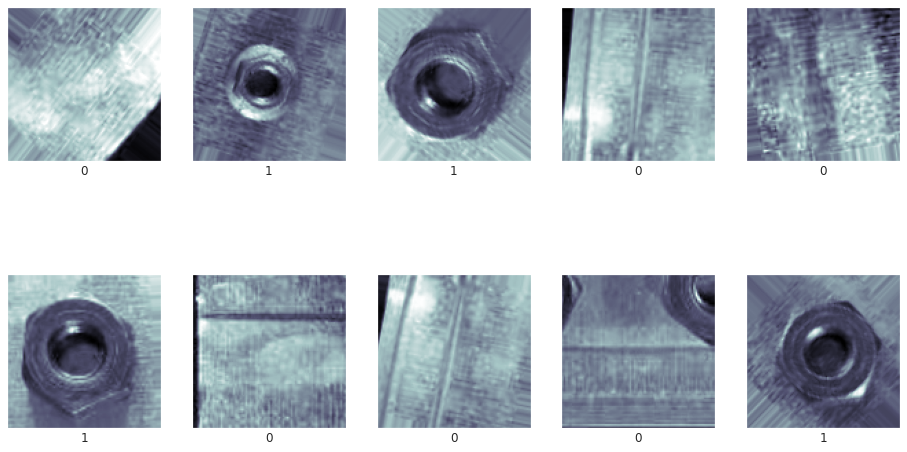

In [39]:
print("Algunos ejemplos aleatorios con sus respectivos Targets: \n",)
fig, ax = plt.subplots(2,5,figsize=(16,9))
for i, ax_i in enumerate(ax.flat):
  n =i+np.random.randint(len(images))
  ax_i.imshow(images[n],cmap="bone")
  ax_i.set(xticks=[],yticks=[],xlabel=targets[n])

### Prepare data

In [40]:
# DATA_TRAIN Y DATA_TEST
Porcentaje_Data_Test= 0.3
images_train, images_test, y_train, y_test = train_test_split(images, targets, test_size= Porcentaje_Data_Test,stratify=targets)

x_train = detect_descriptor(images_train)
x_test = detect_descriptor(images_test)

y_train_hoc = to_categorical(y_train)
y_test_hoc = to_categorical(y_test)

x_train = np.asarray(x_train)#.astype('float32')
x_test = np.asarray(x_test)#.astype('float32')

print("Datos para entrenamiento ",len(x_train))
print("Datos para test ",len(x_test))

Extracting features...
Extracting features...
Datos para entrenamiento  806
Datos para test  346


### Model and training

Epoch 1/100
81/81 [==============================] - 2s 11ms/step - loss: 2.1425 - accuracy: 0.5284 - val_loss: 2.0794 - val_accuracy: 0.5000
Epoch 2/100
81/81 [==============================] - 1s 8ms/step - loss: 2.0975 - accuracy: 0.5615 - val_loss: 2.0766 - val_accuracy: 0.5000
Epoch 3/100
81/81 [==============================] - 1s 8ms/step - loss: 2.1315 - accuracy: 0.4745 - val_loss: 2.0759 - val_accuracy: 0.5000
Epoch 4/100
81/81 [==============================] - 1s 8ms/step - loss: 2.0879 - accuracy: 0.5467 - val_loss: 2.0703 - val_accuracy: 0.5000
Epoch 5/100
81/81 [==============================] - 1s 8ms/step - loss: 2.1145 - accuracy: 0.5015 - val_loss: 2.0675 - val_accuracy: 0.9451
Epoch 6/100
81/81 [==============================] - 1s 8ms/step - loss: 2.0888 - accuracy: 0.5005 - val_loss: 2.0652 - val_accuracy: 0.7486
Epoch 7/100
81/81 [==============================] - 1s 8ms/step - loss: 2.0941 - accuracy: 0.5233 - val_loss: 2.0714 - val_accuracy: 0.5000
Epoch 8/100


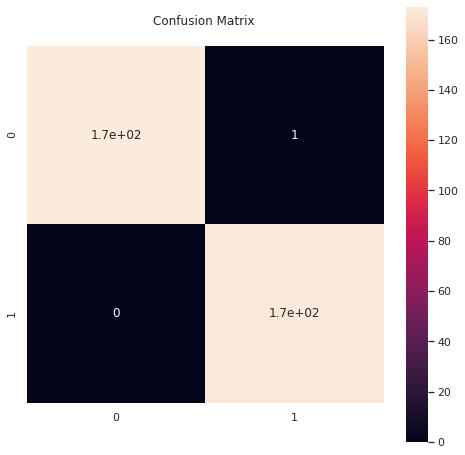

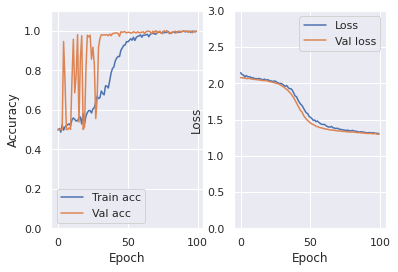

In [41]:
#######################
# input = 8820
model = Sequential()
model.add(Dense(960, activation="sigmoid",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.25)) 
model.add(Dense(320, activation="sigmoid",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.25))
model.add(Dense(30, activation="sigmoid",kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5)))
model.add(Dropout(0.25))
model.add(Dense(2, activation="softmax"))

earlyStop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 20, restore_best_weights=True)

model.compile(loss = "categorical_crossentropy", optimizer="sgd", metrics = ['accuracy'])

history = model.fit(x_train,y_train_hoc,
        epochs= 100,
        batch_size=10,
        callbacks=[earlyStop],
        shuffle=True,
        validation_data=(x_test,y_test_hoc))

#model.summary()

print('\n')
test_loss , test_acc = model.evaluate(x_test,y_test_hoc)

prediction = model.predict(x_test)
pred = []

for i in range(prediction.shape[0]):
  pred.append(prediction[i].argmax())

print("\nPrecisión en el Test: ",test_acc)
print(classification_report(y_test,pred))
mat = confusion_matrix(y_test,pred)
f, ax = plt.subplots(figsize=(8, 8))
ax= sns.heatmap(mat.T, square=True, annot=True, cbar=True)
plt.title("Confusion Matrix \n")
plt.show()

train_history(history)

path_save = "/content/drive/MyDrive/Univalle/Tesis/Tesis V1/"
model.save(path_save+"detection_model.h5")

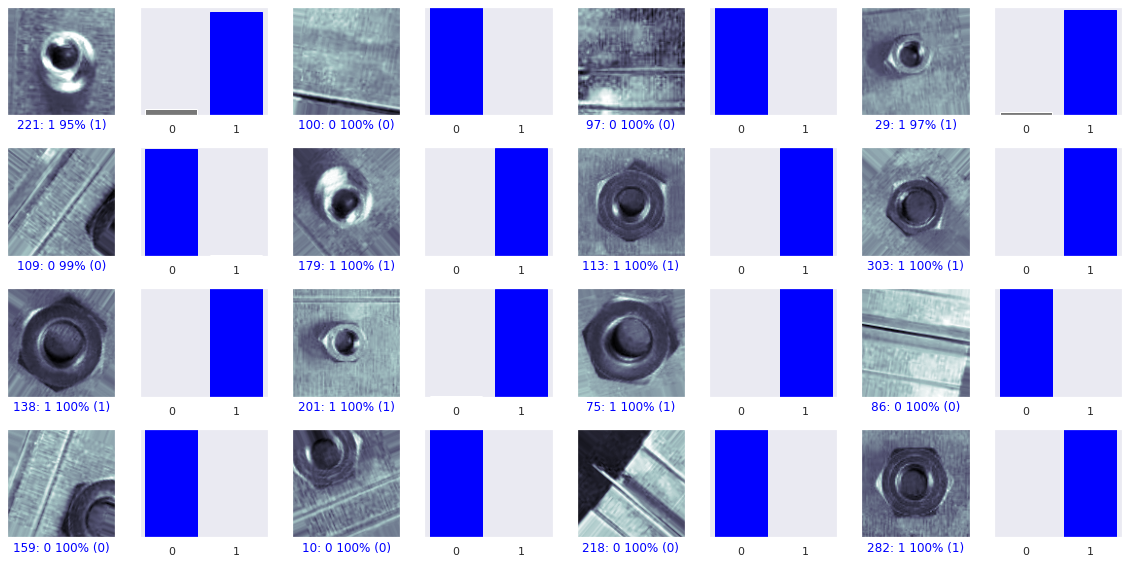

In [42]:
def plot_image(i, predictions_array, true_label, img,class_names = ['0','1']):
  predictions_array, true_label, img = predictions_array, true_label, img
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap='bone')

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{}: {} {:2.0f}% ({})".format(i,class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label
  plt.grid(False)
  plt.xticks(range(2))
  plt.yticks([])
  thisplot = plt.bar(range(2), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  n= np.random.randint(0,x_test.shape[0])
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(n, prediction[n], y_test[n], images_test[n])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(n, prediction[n], y_test[n])
plt.tight_layout()
plt.show()